<a href="https://colab.research.google.com/github/Samyuktha-cvr/calculator/blob/main/Copy_of_TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # Select your .zip file


Saving archive (3).zip to archive (3).zip


In [ ]:
import zipfile
import os

zip_path = "/content/archive (3).zip"  # replace with your uploaded file name

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/extracted_images")


In [ ]:
from PIL import Image
import glob

input_folder = "/content/extracted_images"
output_folder = "/content/jpg_images"
os.makedirs(output_folder, exist_ok=True)

for filepath in glob.glob(f"{input_folder}/*"):
    try:
        with Image.open(filepath) as img:
            rgb_im = img.convert("RGB")
            base = os.path.basename(filepath)
            name, _ = os.path.splitext(base)
            rgb_im.save(f"{output_folder}/{name}.jpg", "JPEG")
    except Exception as e:
        print(f"Error converting {filepath}: {e}")


In [ ]:
!pip install torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import itertools
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
#  Generator: ResNet style
# ------------------------
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residuals=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsample
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        # Residual blocks
        for _ in range(num_residuals):
            model += [ResidualBlock(in_features)]
        # Upsample
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        # Output
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# -----------------------
#  Discriminator: PatchGAN
# -----------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_c, out_c, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),  # shift for output size
            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import os
import shutil

# Input and output folder paths
source_dir = "/content/extracted_images"  # Replace with your actual path
rain_dir = "/content/dataset/rainy/images"
clean_dir = "/content/dataset/clean/images"
unknown_dir = "/content/dataset/unknown"

# Create directories if they don't exist
os.makedirs(rain_dir, exist_ok=True)
os.makedirs(clean_dir, exist_ok=True)
os.makedirs(unknown_dir, exist_ok=True)

# Count how many moved
count_rain = 0
count_clean = 0
count_unknown = 0

# Loop through all files in the source directory
for filename in os.listdir(source_dir):
    filepath = os.path.join(source_dir, filename)

    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue  # skip non-image files

    lower_name = filename.lower()

    if "rain" in lower_name:
        shutil.move(filepath, os.path.join(rain_dir, filename))
        print(f"Moved to RAINY: {filename}")
        count_rain += 1
    elif "clean" in lower_name or "clear" in lower_name or "norain" in lower_name:
        shutil.move(filepath, os.path.join(clean_dir, filename))
        print(f"Moved to CLEAN: {filename}")
        count_clean += 1
    else:
        shutil.move(filepath, os.path.join(unknown_dir, filename))
        print(f"Moved to UNKNOWN: {filename}")
        count_unknown += 1

# Final summary
print("\n==== SORTING SUMMARY ====")
print(f"Rainy images moved:   {count_rain}")
print(f"Clean images moved:   {count_clean}")
print(f"Unknown (manual check needed): {count_unknown}")



==== SORTING SUMMARY ====
Rainy images moved:   0
Clean images moved:   0
Unknown (manual check needed): 0


In [ ]:
source_dir = "/content/extracted_images"


In [ ]:
import os
import shutil
import random

# Path where all images are currently stored
source_dir = "//content/jpg_images"

# Output folders
rain_dir = "/content/dataset/rainy/images"
clean_dir = "/content/dataset/clean/images"

# Create output directories if they don't exist
os.makedirs(rain_dir, exist_ok=True)
os.makedirs(clean_dir, exist_ok=True)

# List all image files (add more extensions if needed)
all_images = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Debug: Check if any images found
print(f"Found {len(all_images)} images in '{source_dir}'")

# Shuffle and split 50/50
random.shuffle(all_images)
mid = len(all_images) // 2
rainy_files = all_images[:mid]
clean_files = all_images[mid:]

# Move rainy images
for f in rainy_files:
    shutil.move(os.path.join(source_dir, f), os.path.join(rain_dir, f))
    print(f"Moved to RAINY: {f}")

# Move clean images
for f in clean_files:
    shutil.move(os.path.join(source_dir, f), os.path.join(clean_dir, f))
    print(f"Moved to CLEAN: {f}")

# Summary
print("\n==== SPLIT COMPLETED ====")
print(f"Rainy images: {len(rainy_files)}")
print(f"Clean images: {len(clean_files)}")


Found 400 images in '//content/jpg_images'
Moved to RAINY: rainstreak-088.jpg
Moved to RAINY: rainregion-064.jpg
Moved to RAINY: rainregion-049.jpg
Moved to RAINY: rainregion-065.jpg
Moved to RAINY: rainregion-030.jpg
Moved to RAINY: rainstreak-035.jpg
Moved to RAINY: rain-078.jpg
Moved to RAINY: rain-030.jpg
Moved to RAINY: rainregion-019.jpg
Moved to RAINY: rainstreak-047.jpg
Moved to RAINY: rainstreak-087.jpg
Moved to RAINY: rainstreak-028.jpg
Moved to RAINY: rainstreak-063.jpg
Moved to RAINY: rainstreak-070.jpg
Moved to RAINY: norain-089.jpg
Moved to RAINY: norain-082.jpg
Moved to RAINY: rain-021.jpg
Moved to RAINY: norain-065.jpg
Moved to RAINY: norain-014.jpg
Moved to RAINY: rainregion-037.jpg
Moved to RAINY: rain-050.jpg
Moved to RAINY: rain-007.jpg
Moved to RAINY: norain-070.jpg
Moved to RAINY: rainstreak-022.jpg
Moved to RAINY: rain-039.jpg
Moved to RAINY: norain-001.jpg
Moved to RAINY: rainregion-048.jpg
Moved to RAINY: rainstreak-097.jpg
Moved to RAINY: rainstreak-084.jpg
Mo

In [ ]:
import torch
import torch.nn as nn

# Basic block for the generator (Residual block)
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator: ResNet-based
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residuals=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsampling
        in_features = 64
        for _ in range(2):
            out_features = in_features * 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        # Residual blocks
        for _ in range(n_residuals):
            model += [ResidualBlock(in_features)]
        # Upsampling
        for _ in range(2):
            out_features = in_features // 2
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Discriminator: PatchGAN
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def conv_block(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *conv_block(in_channels, 64, normalize=False),
            *conv_block(64, 128),
            *conv_block(128, 256),
            *conv_block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# Transform for resizing and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Unpaired datasets
dataset_rain = datasets.ImageFolder('/content/dataset/rainy', transform=transform)
dataset_clean = datasets.ImageFolder('/content/dataset/clean', transform=transform)

loader_rain = DataLoader(dataset_rain, batch_size=1, shuffle=True)
loader_clean = DataLoader(dataset_clean, batch_size=1, shuffle=True)


In [ ]:
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_AB = Generator().to(device)  # Rain → Clean
G_BA = Generator().to(device)  # Clean → Rain
D_A = Discriminator().to(device)  # Discriminator for Rain
D_B = Discriminator().to(device)  # Discriminator for Clean

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

lr = 0.0002
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

# Start training
num_epochs = 10  # Increase to 100+ for better quality
for epoch in range(num_epochs):
    for (data_rain, _), (data_clean, _) in zip(loader_rain, loader_clean):
        real_A = data_rain.to(device)
        real_B = data_clean.to(device)

        # Train Generators
        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))

        recovered_A = G_BA(fake_B)
        recovered_B = G_AB(fake_A)

        loss_cycle_A = criterion_cycle(recovered_A, real_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_B)

        loss_G = loss_GAN_AB + loss_GAN_BA + 10.0 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator A
        optimizer_D_A.zero_grad()
        loss_D_A = (criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A))) +
                    criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_D_B = (criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B))) +
                    criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_G: {loss_G.item():.4f}, D_A: {loss_D_A.item():.4f}, D_B: {loss_D_B.item():.4f}")


Epoch [1/10] Loss_G: 8.5465, D_A: 0.1065, D_B: 0.1807
Epoch [2/10] Loss_G: 10.4062, D_A: 0.0534, D_B: 0.0426
Epoch [3/10] Loss_G: 13.8897, D_A: 0.0809, D_B: 0.6586
Epoch [4/10] Loss_G: 8.8740, D_A: 0.0516, D_B: 0.1487
Epoch [5/10] Loss_G: 5.0177, D_A: 0.4143, D_B: 0.1267
Epoch [6/10] Loss_G: 2.0300, D_A: 0.1763, D_B: 0.2138
Epoch [7/10] Loss_G: 9.3458, D_A: 0.1397, D_B: 0.2411
Epoch [8/10] Loss_G: 6.2220, D_A: 0.0255, D_B: 0.0234
Epoch [9/10] Loss_G: 8.6900, D_A: 0.0588, D_B: 0.0344
Epoch [10/10] Loss_G: 9.1062, D_A: 0.1077, D_B: 0.0369


In [ ]:
torch.save(G_AB.state_dict(), "derain_generator.pth")
print("✅ Trained model saved.")


✅ Trained model saved.


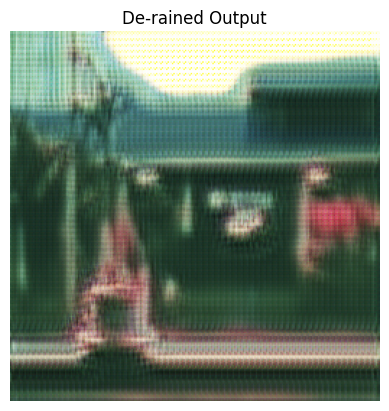

In [ ]:
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Load and preprocess image
image_path = '//content/rain.2.jpg'  # Replace with your test image
img = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

input_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 256, 256]

# Inference
G_AB.eval()
with torch.no_grad():
    output = G_AB(input_tensor).squeeze(0).cpu()
    output = output * 0.5 + 0.5  # Denormalize
    plt.imshow(output.permute(1, 2, 0))  # Convert to [H, W, C]
    plt.title("De-rained Output")
    plt.axis("off")
    plt.show()
